<a href="https://colab.research.google.com/github/hawk20434/Software-tools-for-data-collection/blob/main/LB2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from lxml import html
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://oilprice.com/oil-price-charts/'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
response = requests.get(url, headers=headers)
if response.status_code == 200:
    page_content = response.content
else:
    print(f"Ошибка при получении страницы: {response.status_code}")
    exit()

In [3]:
tree = html.fromstring(page_content)
tree

<Element html at 0x78e10c58e430>

In [4]:
# XPath для извлечения данных из первой таблицы
futures_indexes = tree.xpath('//table[@class="oilprices__table"]//tbody//tr/td[2]/span/text()')
last_prices = tree.xpath('//table[@class="oilprices__table"]//tbody//tr/td[3]/text()')
price_changes = tree.xpath('//table[@class="oilprices__table"]//tbody//tr/td[4]/text()')
percent_changes = tree.xpath('//table[@class="oilprices__table"]//tbody//tr/td[5]/text()')

In [5]:
print(f"Futures & Indexes: {len(futures_indexes)}")
print(f"Last: {len(last_prices)}")
print(f"Change: {len(price_changes)}")
print(f"% Change: {len(percent_changes)}")

Futures & Indexes: 137
Last: 137
Change: 137
% Change: 137


In [6]:
data = {
    'Futures & Indexes': futures_indexes,
    'Last': last_prices,
    'Change': price_changes,
    '% Change': percent_changes            }

df = pd.DataFrame(data)
df

,Futures & Indexes,Last,Change,% Change
0,WTI Crude,67.95,-1.74,-2.5%
1,Brent Crude,71.67,-1.79,-2.44%
2,Murban Crude,71.69,-1.91,-2.6%
3,Natural Gas,2.661,+0.024,+0.91%
4,Gasoline,1.963,-0.037,-1.86%
...,...,...,...,...
132,Iran Heavy,83.65,-0.48,-0.57%
133,Kuwait Export,84.91,-0.24,-0.28%
134,Merey,69.23,-1.32,-1.87%
135,Murban,82.51,-1.59,-1.89%


In [7]:
df['Last'] = pd.to_numeric(df['Last'], errors='coerce')
df['Change'] = pd.to_numeric(df['Change'], errors='coerce')
df['% Change'] = df['% Change'].str.replace('%', '', regex=False).astype(float) / 100

In [8]:
# 5 инструментов с наибольшей волатильностью
top_volatile = df.nlargest(5, '% Change')
# 5 инструментов с наименьшей волатильностью
least_volatile = df.nsmallest(5, '% Change')

print("Наиболее волатильные инструменты:")
print(top_volatile[['Futures & Indexes', '% Change']])
print("\nНаименее волатильные инструменты:")
print(least_volatile[['Futures & Indexes', '% Change']])

Наиболее волатильные инструменты:
     Futures & Indexes  % Change
49             Cossack    0.0370
105  South Texas Heavy    0.0290
123      Oklahoma Sour    0.0228
99    South Texas Sour    0.0220
10            DME Oman    0.0214

Наименее волатильные инструменты:
          Futures & Indexes  % Change
14  Western Canadian Select   -0.0322
77                    Cinta   -0.0310
79                    Minas   -0.0303
82         Tapis (Malaysia)   -0.0290
34                   Marine   -0.0287


In [9]:
# статистика по колонкам 'Last', 'Change', и '% Change'
stats = df[['Last', 'Change', '% Change']].describe()
print("Статистика по ценам и изменениям:")
print(stats)

Статистика по ценам и изменениям:
             Last      Change    % Change
count  137.000000  137.000000  137.000000
mean    67.446555    0.110555    0.001855
std     14.890285    1.183244    0.017429
min      1.610000   -2.390000   -0.032200
25%     65.250000   -0.360000   -0.011400
50%     70.040000    0.330000    0.004900
75%     75.030000    1.190000    0.017800
max     85.310000    2.670000    0.037000


In [10]:
# сравним инструменты по росту и падению
df['Trend'] = df['Change'].apply(lambda x: 'Рост' if x > 0 else 'Падение')
trend_counts = df['Trend'].value_counts()
print("Количество инструментов с ростом и падением:")
print(trend_counts)
rising = df[df['Trend'] == 'Рост']
falling = df[df['Trend'] == 'Падение']
print("\nИнструменты с ростом:")
print(rising[['Futures & Indexes', 'Last', 'Change', '% Change']].head())
print("\nИнструменты с падением:")
print(falling[['Futures & Indexes', 'Last', 'Change', '% Change']].head())

Количество инструментов с ростом и падением:
Trend
Рост       91
Падение    46
Name: count, dtype: int64

Инструменты с ростом:
   Futures & Indexes    Last  Change  % Change
3        Natural Gas   2.661   0.024    0.0091
7               Mars  75.550   0.780    0.0104
8        Opec Basket  75.120   0.680    0.0091
10          DME Oman  75.360   1.580    0.0214
11    Mexican Basket  67.310   1.140    0.0172

Инструменты с падением:
  Futures & Indexes    Last  Change  % Change
0         WTI Crude  67.950  -1.740   -0.0250
1       Brent Crude  71.670  -1.790   -0.0244
2      Murban Crude  71.690  -1.910   -0.0260
4          Gasoline   1.963  -0.037   -0.0186
5       Heating Oil   2.114  -0.046   -0.0213


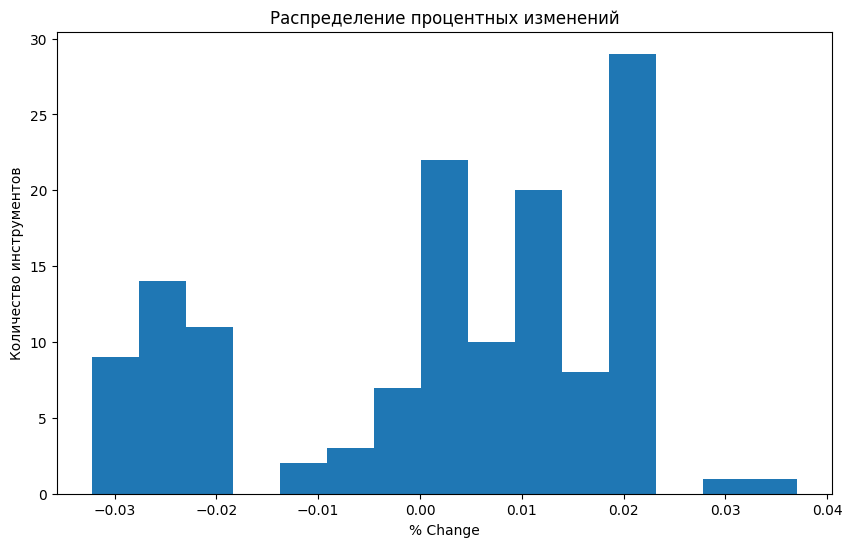

In [11]:
# Построим гистограмму распределения % Change
plt.figure(figsize=(10,6))
plt.hist(df['% Change'], bins=15)
plt.title('Распределение процентных изменений')
plt.xlabel('% Change')
plt.ylabel('Количество инструментов')
plt.show()

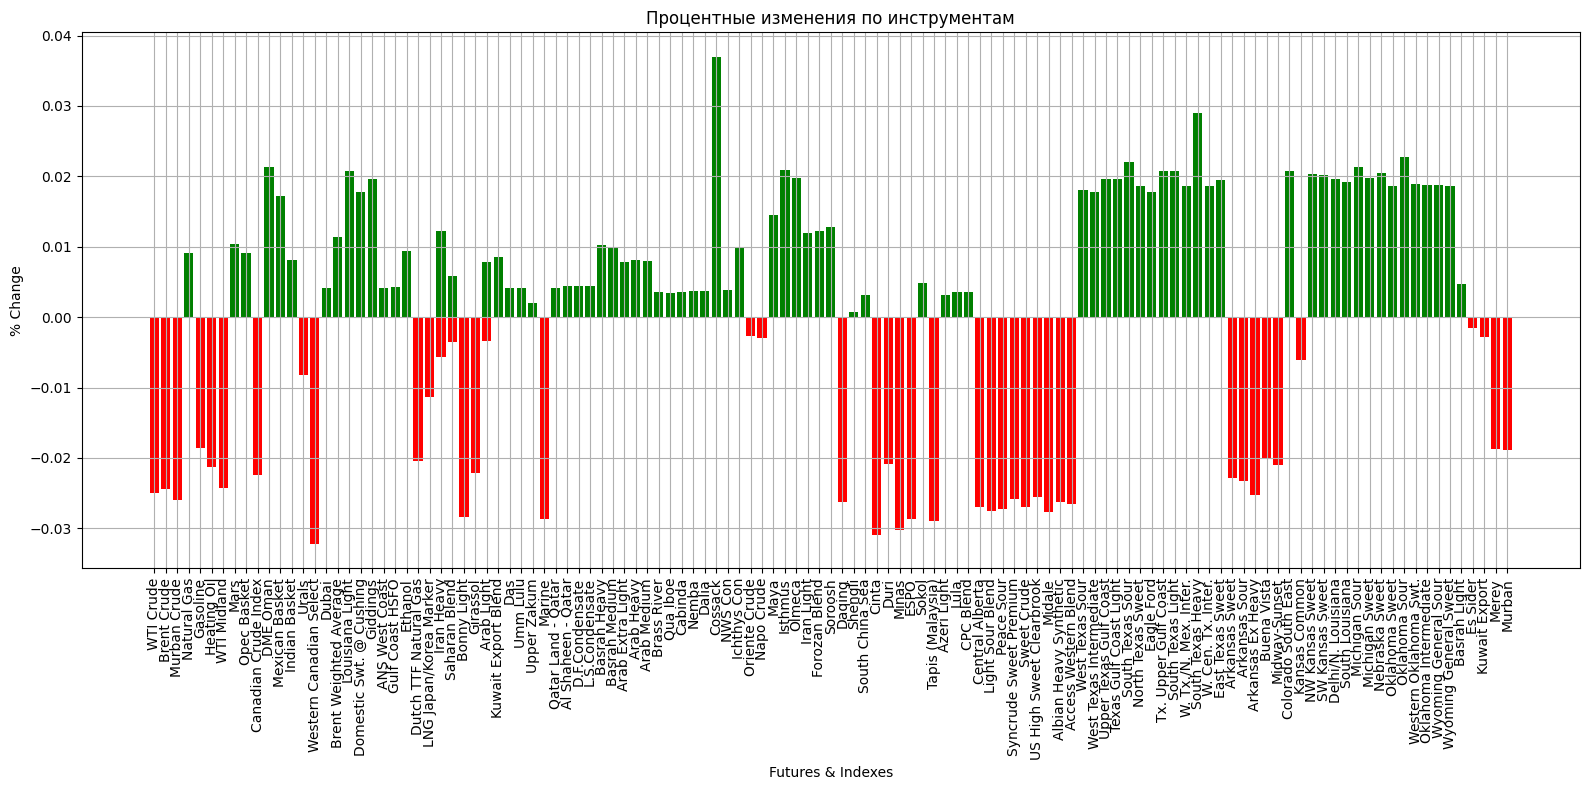

In [12]:
colors = ['green' if x > 0 else 'red' for x in df['% Change']]
plt.figure(figsize=(16, 8))
plt.bar(df['Futures & Indexes'], df['% Change'], color=colors)
plt.title('Процентные изменения по инструментам')
plt.xlabel('Futures & Indexes')
plt.ylabel('% Change')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
df.to_csv('oil.csv', index=False)
# скачать файл
from google.colab import files
files.download('oil.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>